In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch 
import torch.nn as nn
import torchvision.transforms as transforms

from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import Lambda, Compose, ToTensor

from typing import Tuple, List
from copy import deepcopy, copy

np.random.seed(255)

## Hyperparameters

In [2]:
num_epochs = 10
batch_size = 1000
learning_rate = 0.001

### Load dataset: MNIST

In [3]:
train_dataset = MNIST(
    root='.',
    download=True,
    train=True, 
    )

test_dataset = MNIST(
    root='.',
    download=True,
    train=False, 
)


train_dataset.data = (train_dataset.data/255.0)  
test_dataset.data = (test_dataset.data/255.0)


def calculate_mean_and_std() -> Tuple[float, float]:
    mean = train_dataset.data.mean()
    std = train_dataset.data.std()
    return mean, std

mean, std = calculate_mean_and_std()

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        #transforms.Lambda(lambda x: x.view(28,28)),
        transforms.Lambda(lambda x: (x-mean)/std),       
]) 


train_dataset = MNIST(
    root = '.', 
    download = True, 
    train = True, 
    transform = transform
)

test_dataset = MNIST(
    root='.',
    download=True,
    train=False, 
    transform = transform
)

In [5]:
train_loader  = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

In [6]:
x,y = next(iter(train_loader))
#assert len(x.shape) == 4
#assert x.shape == (100, 1, 28,28)

print(x.shape)
print(y.shape,"\n")

print("Checking, whether normalization in transforms is working.")

for i in range(100):
    if i%15==0:
        print("Sample image in bath size:\t mean(x) = {:}\t std(x)={:}".format(x[i].mean(), x[i].std()))

torch.Size([1000, 1, 28, 28])
torch.Size([1000]) 

Checking, whether normalization in transforms is working.
Sample image in bath size:	 mean(x) = 0.09087136387825012	 std(x)=1.0827609300613403
Sample image in bath size:	 mean(x) = -0.08438092470169067	 std(x)=0.8992922902107239
Sample image in bath size:	 mean(x) = -0.0673183798789978	 std(x)=0.9185518026351929
Sample image in bath size:	 mean(x) = -0.1180514544248581	 std(x)=0.8702222108840942
Sample image in bath size:	 mean(x) = -0.059038739651441574	 std(x)=0.941189706325531
Sample image in bath size:	 mean(x) = -0.09592371433973312	 std(x)=0.8732141256332397
Sample image in bath size:	 mean(x) = 0.05182718113064766	 std(x)=1.0561859607696533


## Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, padding=2), #1 * 28 * 28 -> 4 * 28 * 28
            nn.BatchNorm2d(4),                         #4 * 28 * 28
            nn.ReLU())                                 #4 * 28 * 28       
        self.layer2  = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5, padding=2), #4 * 28 * 28 -> 8 * 28* 28
            nn.BatchNorm2d(8),                         #8 * 28 * 28
            nn.ReLU())                                 #8 * 28 * 28        
        self.layer3  = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # 8 * 28 * 28 -> 16 * 28* 28
            nn.BatchNorm2d(16),                         #16 * 28 * 28
            nn.ReLU())                                  #16 * 28 * 28      
        self.layer4  = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),#16 * 28 * 28 -> 32 * 28* 28
            nn.BatchNorm2d(32),                         #32 * 28 * 28
            nn.ReLU())                                  #32 * 28 * 28      
        self.fc = nn.Linear(32 * 28 * 28, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = CNN()

## Train the model

In [8]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
            
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
        if (i+1) % 100 == 0:
            print("epoch, ",epoch,"loss - ", loss, )
    print("epoch, ",epoch,"loss - ", loss, )

epoch,  0 loss -  tensor(0.1254, grad_fn=<NllLossBackward>)
epoch,  1 loss -  tensor(0.0812, grad_fn=<NllLossBackward>)
epoch,  2 loss -  tensor(0.0422, grad_fn=<NllLossBackward>)
epoch,  3 loss -  tensor(0.0447, grad_fn=<NllLossBackward>)
epoch,  4 loss -  tensor(0.0253, grad_fn=<NllLossBackward>)
epoch,  5 loss -  tensor(0.0232, grad_fn=<NllLossBackward>)
epoch,  6 loss -  tensor(0.0152, grad_fn=<NllLossBackward>)
epoch,  7 loss -  tensor(0.0180, grad_fn=<NllLossBackward>)
epoch,  8 loss -  tensor(0.0117, grad_fn=<NllLossBackward>)
epoch,  9 loss -  tensor(0.0092, grad_fn=<NllLossBackward>)


## Test the model

In [11]:
PATH = './model.pth'

model.load_state_dict(torch.load(PATH))
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Linear(in_features=25088, out_features=10, bias=True)
)

In [12]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.84 %


In [ ]:
#commented to not overwrite trained model
#PATH = './model.pth'   
#torch.save(model.state_dict(), PATH)

## Model Paramteres, weights and so on

In [13]:
print("Model's state_dict:")

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
#for param_tensor in model.state_dict():
#    print("\n\n\n",  model.state_dict()[param_tensor])


Model's state_dict:
layer1.0.weight 	 torch.Size([4, 1, 5, 5])
layer1.0.bias 	 torch.Size([4])
layer1.1.weight 	 torch.Size([4])
layer1.1.bias 	 torch.Size([4])
layer1.1.running_mean 	 torch.Size([4])
layer1.1.running_var 	 torch.Size([4])
layer1.1.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([8, 4, 5, 5])
layer2.0.bias 	 torch.Size([8])
layer2.1.weight 	 torch.Size([8])
layer2.1.bias 	 torch.Size([8])
layer2.1.running_mean 	 torch.Size([8])
layer2.1.running_var 	 torch.Size([8])
layer2.1.num_batches_tracked 	 torch.Size([])
layer3.0.weight 	 torch.Size([16, 8, 5, 5])
layer3.0.bias 	 torch.Size([16])
layer3.1.weight 	 torch.Size([16])
layer3.1.bias 	 torch.Size([16])
layer3.1.running_mean 	 torch.Size([16])
layer3.1.running_var 	 torch.Size([16])
layer3.1.num_batches_tracked 	 torch.Size([])
layer4.0.weight 	 torch.Size([32, 16, 5, 5])
layer4.0.bias 	 torch.Size([32])
layer4.1.weight 	 torch.Size([32])
layer4.1.bias 	 torch.Size([32])
layer4.1.running_mean 	 torch.

In [75]:
weights_1 =  deepcopy(model.state_dict()['layer1.0.weight']).detach().numpy()
weights_2 =  deepcopy(model.state_dict()['layer2.0.weight']).detach().numpy()
weights_3 =  deepcopy(model.state_dict()['layer3.0.weight']).detach().numpy()
weights_4 =  deepcopy(model.state_dict()['layer4.0.weight']).detach().numpy()

In [76]:
print("shape weights1: {:}".format(weights_1.shape))
print("shape weights2: {:}".format(weights_2.shape))
print("shape weights3: {:}".format(weights_3.shape))
print("shape weights4: {:}".format(weights_4.shape))

shape weights1: (4, 1, 5, 5)
shape weights2: (8, 4, 5, 5)
shape weights3: (16, 8, 5, 5)
shape weights4: (32, 16, 5, 5)


In [77]:
channels_connections_1 = weights_1.shape[0]*weights_1.shape[1]
kernel_1 = weights_1.shape[2]*weights_1.shape[3]

channels_connections_2 = weights_2.shape[0]*weights_2.shape[1]
kernel_2 = weights_2.shape[2]*weights_2.shape[3]

channels_connections_3 = weights_3.shape[0]*weights_3.shape[1]
kernel_3 = weights_3.shape[2]*weights_3.shape[3]

channels_connections_4 = weights_4.shape[0]*weights_4.shape[1]
kernel_4 = weights_4.shape[2]*weights_4.shape[3]


weights_1 = weights_1.reshape(channels_connections_1, kernel_1)
weights_2 = weights_2.reshape(channels_connections_2, kernel_2)
weights_3 = weights_3.reshape(channels_connections_3, kernel_3)
weights_4 = weights_4.reshape(channels_connections_4, kernel_4)
print()

In [92]:
kernel_means_1 = []
kernel_variance_1 = []

for i in range(channels_connections_1):
    kernel_means_1.append(weights_1[i].mean())
    kernel_variance_1.append(weights_1[i].var())

In [91]:
kernel_means_2 = []
kernel_variance_2 = []

for i in range(channels_connections_2):
    kernel_means_2.append(weights_2[i].mean())
    kernel_variance_2.append(weights_2[i].var())

In [93]:
kernel_means_3 = []
kernel_variance_3 = []

for i in range(channels_connections_3):
    kernel_means_3.append(weights_3[i].mean())
    kernel_variance_3.append(weights_3[i].var())

In [94]:
kernel_means_4 = []
kernel_variance_4 = []

for i in range(channels_connections_4):
    kernel_means_4.append(weights_4[i].mean())
    kernel_variance_4.append(weights_4[i].var())

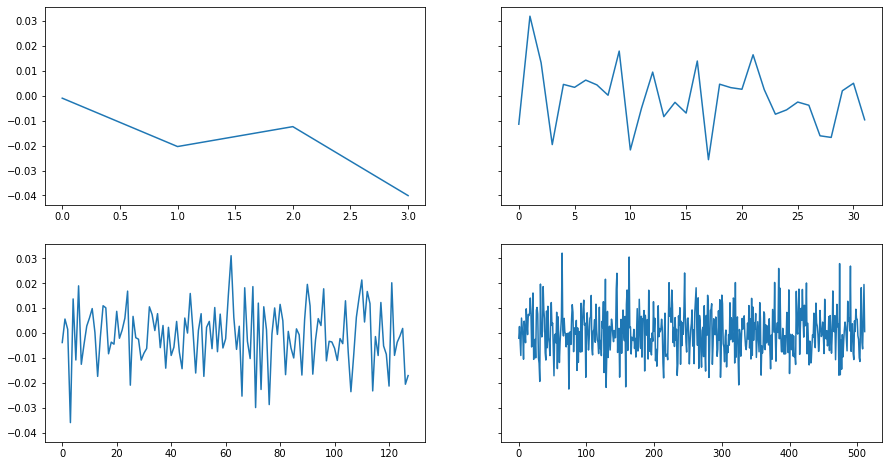

In [95]:
fig, axs = plt.subplots(2, 2, figsize= (15,8), sharex=False, sharey=True)

axs[0][0].plot(kernel_means_1)
axs[0][1].plot(kernel_means_2)
axs[1][0].plot(kernel_means_3)
axs[1][1].plot(kernel_means_4)

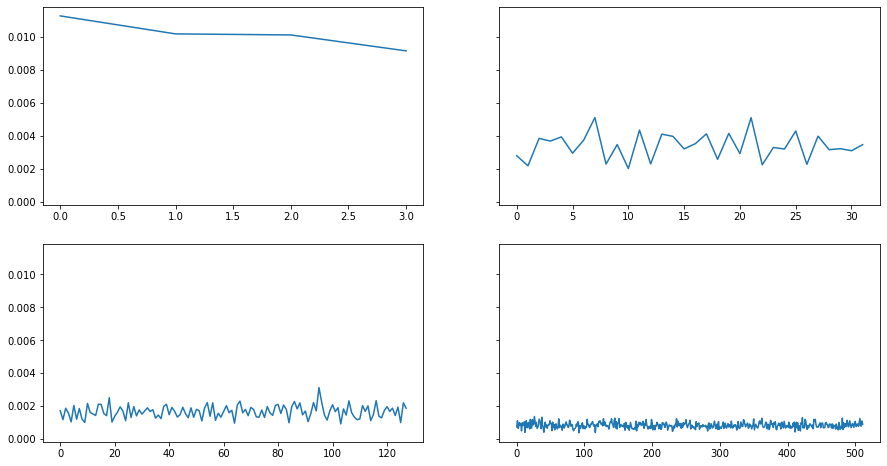

In [97]:
fig, axs = plt.subplots(2, 2, figsize= (15,8), sharex=False, sharey=True)

axs[0][0].plot(kernel_variance_1)
axs[0][1].plot(kernel_variance_2)
axs[1][0].plot(kernel_variance_3)
axs[1][1].plot(kernel_variance_4)


## Get inside - show out images on each layer

In [12]:
class CNN_layer1(nn.Module):
    def __init__(self):
        super(CNN_layer1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, padding=2), #1 * 28 * 28 -> 4 * 28 * 28
            nn.BatchNorm2d(4),                         #4 * 28 * 28
            nn.ReLU())                                 #4 * 28 * 28      
        self.layer2  = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5, padding=2), #4 * 28 * 28 -> 8 * 28* 28
            nn.BatchNorm2d(8),                         #8 * 28 * 28
            nn.ReLU())                                 #8 * 28 * 28      
        self.layer3  = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # 8 * 28 * 28 -> 16 * 28* 28
            nn.BatchNorm2d(16),                         #16 * 28 * 28
            nn.ReLU())                                  #16 * 28 * 28     
        self.layer4  = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),#16 * 28 * 28 -> 32 * 28* 28
            nn.BatchNorm2d(32),                         #32 * 28 * 28
            nn.ReLU())                                  #32 * 28 * 28      
        self.fc = nn.Linear(32 * 28 * 28, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        return out

    
class CNN_layer2(nn.Module):
    def __init__(self):
        super(CNN_layer2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, padding=2), #1 * 28 * 28 -> 4 * 28 * 28
            nn.BatchNorm2d(4),                         #4 * 28 * 28
            nn.ReLU())                                 #4 * 28 * 28
        self.layer2  = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5, padding=2), #4 * 28 * 28 -> 8 * 28* 28
            nn.BatchNorm2d(8),                         #8 * 28 * 28
            nn.ReLU())                                 #8 * 28 * 28
        self.layer3  = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # 8 * 28 * 28 -> 16 * 28* 28
            nn.BatchNorm2d(16),                         #16 * 28 * 28
            nn.ReLU())                                  #16 * 28 * 28       
        self.layer4  = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),#16 * 28 * 28 -> 32 * 28* 28
            nn.BatchNorm2d(32),                         #32 * 28 * 28
            nn.ReLU())                                  #32 * 28 * 28      
        self.fc = nn.Linear(32 * 28 * 28, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

    
class CNN_layer3(nn.Module):
    def __init__(self):
        super(CNN_layer3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, padding=2), #1 * 28 * 28 -> 4 * 28 * 28
            nn.BatchNorm2d(4),                         #4 * 28 * 28
            nn.ReLU())                                 #4 * 28 * 28
        self.layer2  = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5, padding=2), #4 * 28 * 28 -> 8 * 28* 28
            nn.BatchNorm2d(8),                         #8 * 28 * 28
            nn.ReLU())                                 #8 * 28 * 28
        self.layer3  = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # 8 * 28 * 28 -> 16 * 28* 28
            nn.BatchNorm2d(16),                         #16 * 28 * 28
            nn.ReLU())                                  #16 * 28 * 28
        self.layer4  = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),#16 * 28 * 28 -> 32 * 28* 28
            nn.BatchNorm2d(32),                         #32 * 28 * 28
            nn.ReLU())                                  #32 * 28 * 28      
        self.fc = nn.Linear(32 * 28 * 28, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
    
class CNN_layer4(nn.Module):
    def __init__(self):
        super(CNN_layer4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, padding=2), #1 * 28 * 28 -> 4 * 28 * 28
            nn.BatchNorm2d(4),                         #4 * 28 * 28
            nn.ReLU())                                 #4 * 28 * 28
        self.layer2  = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5, padding=2), #4 * 28 * 28 -> 8 * 28* 28
            nn.BatchNorm2d(8),                         #8 * 28 * 28
            nn.ReLU())                                 #8 * 28 * 28
        self.layer3  = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # 8 * 28 * 28 -> 16 * 28* 28
            nn.BatchNorm2d(16),                         #16 * 28 * 28
            nn.ReLU())                                  #16 * 28 * 28
        self.layer4  = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),#16 * 28 * 28 -> 32 * 28* 28
            nn.BatchNorm2d(32),                         #32 * 28 * 28
            nn.ReLU())                                  #32 * 28 * 28      
        self.fc = nn.Linear(32 * 28 * 28, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [14]:
layer1 = CNN_layer1()
layer1.load_state_dict(torch.load(PATH))
layer1.eval()

layer2 = CNN_layer2()
layer2.load_state_dict(torch.load(PATH))
layer2.eval()

layer3 = CNN_layer3()
layer3.load_state_dict(torch.load(PATH))
layer3.eval()

layer4 = CNN_layer4()
layer4.load_state_dict(torch.load(PATH))
layer4.eval()

CNN_layer4(
  (layer1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Linear(in_features=25088, out_features=10, bias=True)
)

In [15]:
print("Layer1's state_dict:")

for param_tensor in layer1.state_dict():
    print(param_tensor, "\t", layer1.state_dict()[param_tensor].size())

Layer1's state_dict:
layer1.0.weight 	 torch.Size([4, 1, 5, 5])
layer1.0.bias 	 torch.Size([4])
layer1.1.weight 	 torch.Size([4])
layer1.1.bias 	 torch.Size([4])
layer1.1.running_mean 	 torch.Size([4])
layer1.1.running_var 	 torch.Size([4])
layer1.1.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([8, 4, 5, 5])
layer2.0.bias 	 torch.Size([8])
layer2.1.weight 	 torch.Size([8])
layer2.1.bias 	 torch.Size([8])
layer2.1.running_mean 	 torch.Size([8])
layer2.1.running_var 	 torch.Size([8])
layer2.1.num_batches_tracked 	 torch.Size([])
layer3.0.weight 	 torch.Size([16, 8, 5, 5])
layer3.0.bias 	 torch.Size([16])
layer3.1.weight 	 torch.Size([16])
layer3.1.bias 	 torch.Size([16])
layer3.1.running_mean 	 torch.Size([16])
layer3.1.running_var 	 torch.Size([16])
layer3.1.num_batches_tracked 	 torch.Size([])
layer4.0.weight 	 torch.Size([32, 16, 5, 5])
layer4.0.bias 	 torch.Size([32])
layer4.1.weight 	 torch.Size([32])
layer4.1.bias 	 torch.Size([32])
layer4.1.running_mean 	 torch

In [16]:
print(model.state_dict()['layer1.0.bias'])
print(layer1.state_dict()['layer1.0.bias'])
print(layer2.state_dict()['layer1.0.bias'])
print(layer3.state_dict()['layer1.0.bias'])
print(layer4.state_dict()['layer1.0.bias'])

tensor([0.1103, 0.1363, 0.1206, 0.1041])
tensor([0.1103, 0.1363, 0.1206, 0.1041])
tensor([0.1103, 0.1363, 0.1206, 0.1041])
tensor([0.1103, 0.1363, 0.1206, 0.1041])
tensor([0.1103, 0.1363, 0.1206, 0.1041])


## See pictures layer after layer

In [17]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=1,
                                         shuffle=True)
x,y = next(iter(test_loader))

image size = torch.Size([28, 28])


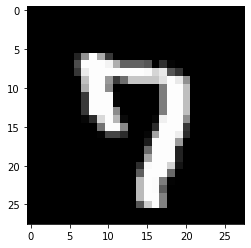

In [18]:
image = x[0][0]
print("image size = {:}".format(image.size()))
plt.imshow(image, cmap='gray')

output size:
layer1.size = torch.Size([1, 4, 28, 28])
layer2.size = torch.Size([1, 8, 28, 28])
layer3.size = torch.Size([1, 16, 28, 28])
layer4.size = torch.Size([1, 32, 28, 28])


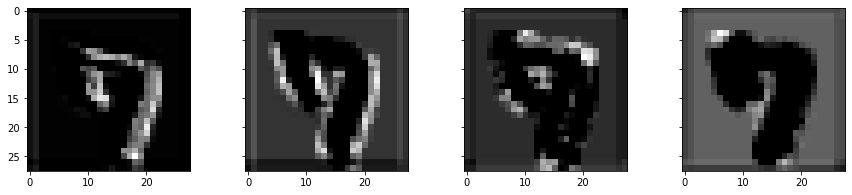

In [20]:
outputs1 = layer1(x)
outputs2 = layer2(x)
outputs3 = layer3(x)
outputs4 = layer4(x)

print("output size:")
print("layer1.size = {:}\nlayer2.size = {:}".format(outputs1.size(), outputs2.size()))
print("layer3.size = {:}\nlayer4.size = {:}".format(outputs3.size(), outputs4.size()))


image1 = outputs1[0]
image2 = outputs2[0]
image3 = outputs3[0]
image4 = outputs4[0]

n_channels1 = len(image1)
n_channels2 = len(image2)
n_channels3 = len(image3)
n_channels4 = len(image4)

n_rows1 = int(n_channels1/4)
n_rows2 = int(n_channels2/4)
n_rows3 = int(n_channels3/4)
n_rows4 = int(n_channels4/4)


fig, axs = plt.subplots(n_rows1, 4, figsize=(15, 3), sharey=True, sharex = True)
for j in range(4):
    image = image1[j]
    axs[j].imshow(image.detach().numpy(), cmap='gray')

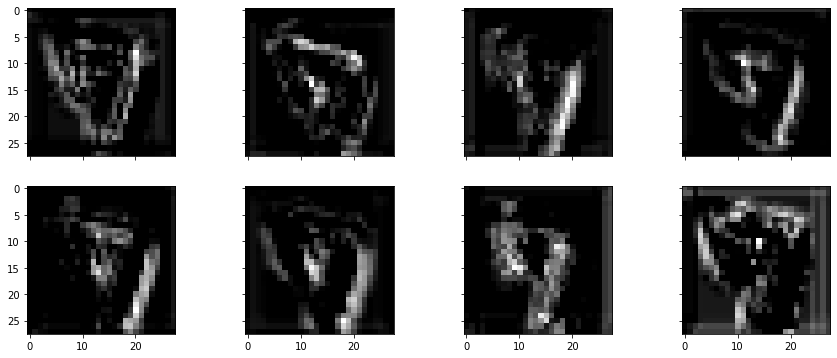

In [21]:
fig, axs = plt.subplots(n_rows2, 4, figsize=(15, 6), sharey=True, sharex = True)
for i in range(n_rows2):
    for j in range(4):
        index = int(4*i+j)
        image = image2[index]
        axs[i][j].imshow(image.detach().numpy(), cmap='gray')

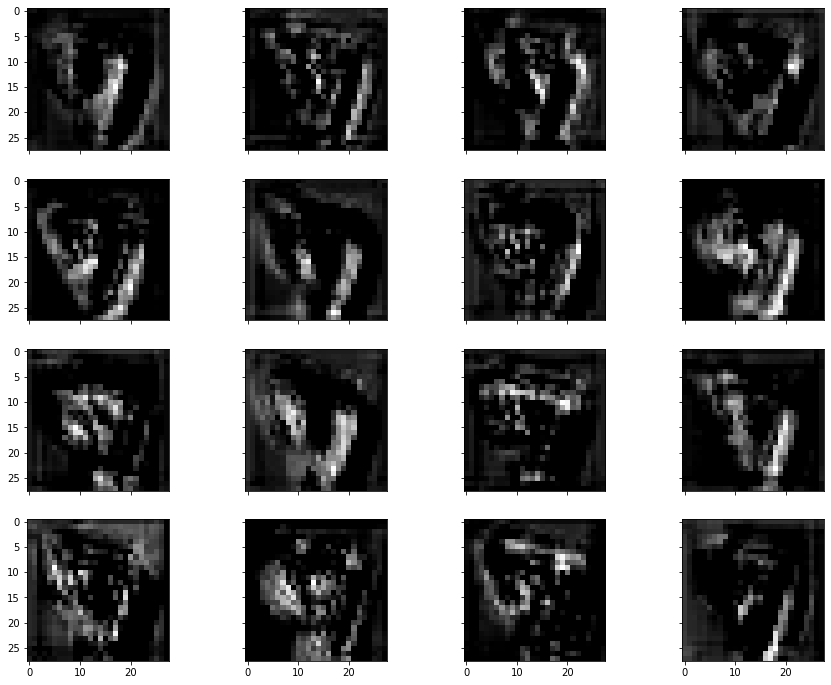

In [25]:
fig, axs = plt.subplots(n_rows3, 4, figsize=(15, 12), sharey=True, sharex = True)
for i in range(n_rows3):
    for j in range(4):
        index = int(4*i+j)
        image = image3[index]
        axs[i][j].imshow(image.detach().numpy(), cmap='gray')

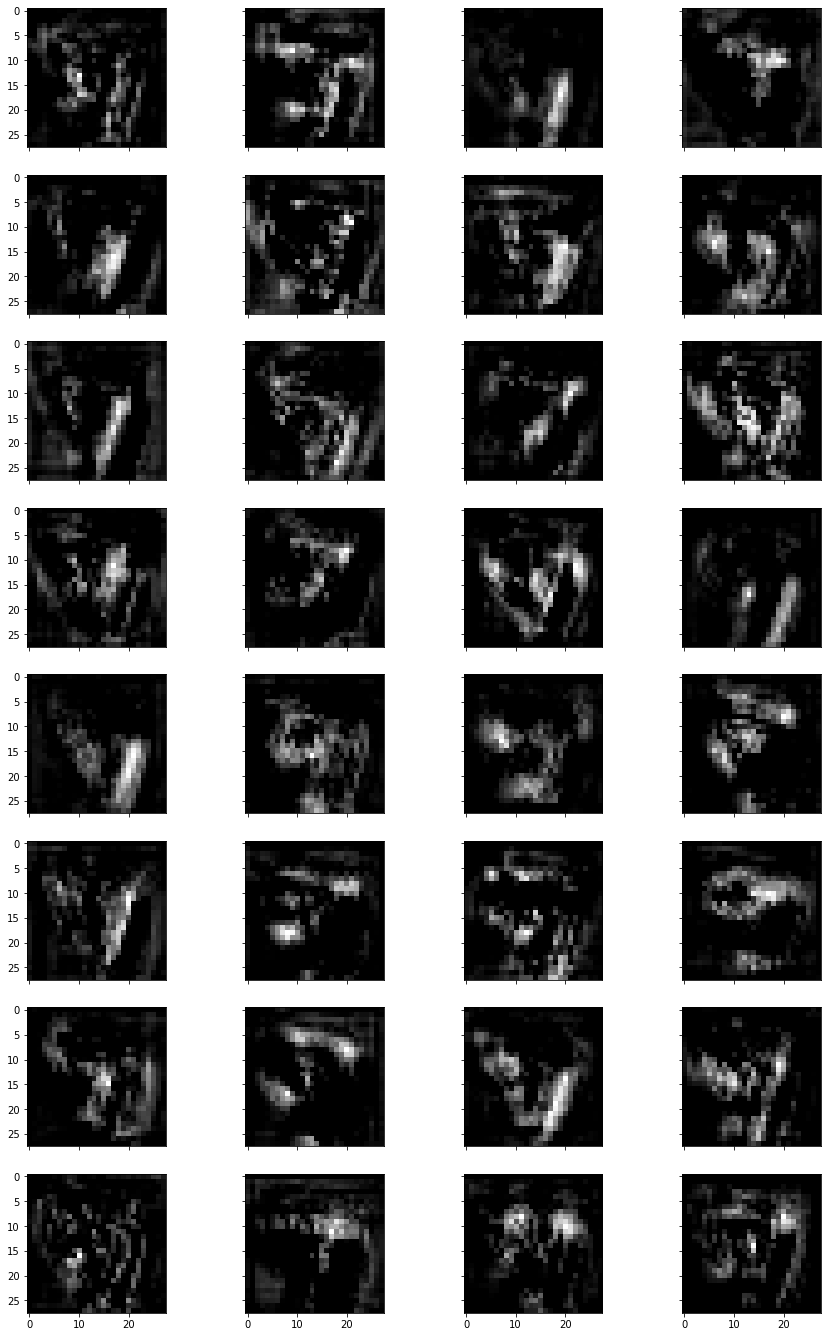

In [24]:
fig, axs = plt.subplots(n_rows4, 4, figsize=(15, 24), sharey=True, sharex = True)
for i in range(n_rows4):
    for j in range(4):
        index = int(4*i+j)
        image = image4[index]
        axs[i][j].imshow(image.detach().numpy(), cmap='gray')